#  Автоэнкодеры

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.eecs.qmul.ac.uk/~sgg/_ECS795P_/papers/WK07-8_PyTorch_Tutorial2.html
* https://www.youtube.com/watch?v=zp8clK9yCro
* https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
* https://towardsdatascience.com/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a
* https://pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py

## Задачи для совместного разбора

1\. Обсудите основные шаги в обучении автокодировщиков.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Загрузите набор данных MNIST из пакета `torchvision` (данный набор уже разбит на обучающее и тестовое множество).

Создайте и обучите модель автокодировщика, используя только полносвязные слои и функции активации.

Кодировщик - это функция вида
$z = f_\theta(x)$
,где $\theta$ - это параметры кодировщика.

Декодировщик - это функция вида
$\hat{x} = g_\phi(z)$
,где $\phi$ - это параметры декодировщика.

В нашем случае оба компонента представляют собой нейронные сети. Скрытое представление, полученное после части-кодировщика, должно иметь размерность 2. Последним слоем части-декодеровщика сделайте сигмоиду.

В качестве функции потерь используйте `MSELoss` между исходным и восстановленным изображением $MSE(x, \hat{x})$.

Обратите внимание, что во время обучения метки классов не используются.


- [ ] Проверено на семинаре

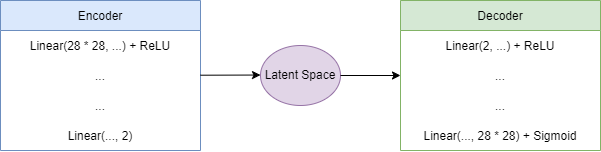

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
device

device(type='cuda')

In [ ]:
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


In [ ]:
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
class AE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 28*28), nn.Sigmoid()
        )

    def encode(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

In [ ]:
model = AE(latent_dim=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
def train_epoch():
    model.train()
    total = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, _ = model(x)
        loss = criterion(x_hat, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item() * x.size(0)
    return total / len(train_loader.dataset)

In [ ]:
@torch.no_grad()
def eval_epoch():
    model.eval()
    total = 0.0
    for x, _ in test_loader:
        x = x.to(device)
        x_hat, _ = model(x)
        loss = criterion(x_hat, x)
        total += loss.item() * x.size(0)
    return total / len(test_loader.dataset)

In [ ]:
for epoch in range(1, 11):
    tr = train_epoch()
    te = eval_epoch()
    print(f"Epoch {epoch:02d}: train={tr:.5f} test={te:.5f}")

Epoch 01: train=0.06120 test=0.04915
Epoch 02: train=0.04677 test=0.04471
Epoch 03: train=0.04359 test=0.04283
Epoch 04: train=0.04189 test=0.04164
Epoch 05: train=0.04085 test=0.04064
Epoch 06: train=0.03994 test=0.03976
Epoch 07: train=0.03933 test=0.03974
Epoch 08: train=0.03880 test=0.03900
Epoch 09: train=0.03836 test=0.03870
Epoch 10: train=0.03801 test=0.03821


<p class="task" id="2"></p>

2\. Получите один батч из тестового множества. Используя модель, обученную в предыдущем задании, получите скрытые представления для всех изображений из этого батча и визуализируйте на плоскости (они должны иметь размерность 2!). Раскрасьте точки в цвета, соответствующие меткам класса изображений (цифрам).

Возьмите одно изображение из тестового множества и пропустите его через обученный автокодировщик. Визуализируйте рядом (по горизонтали) два изображения: исходное и после восстановления автокодировщиком.


- [ ] Проверено на семинаре

In [ ]:
model = model.to(device)
model.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
x_batch, y_batch = next(iter(test_loader))
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)

In [ ]:
with torch.no_grad():
    z = model.encode(x_batch)
    z = z.cpu().numpy()
    y = y_batch.cpu().numpy()

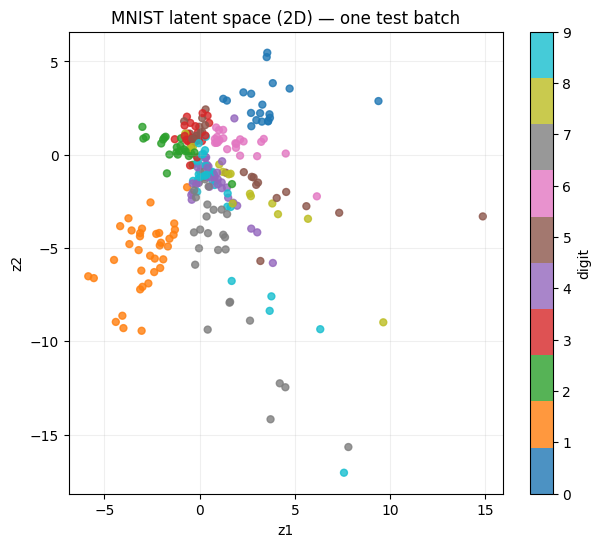

In [ ]:
plt.figure(figsize=(7, 6))
sc = plt.scatter(z[:, 0], z[:, 1], c=y, cmap="tab10", s=25, alpha=0.8)
plt.colorbar(sc, ticks=range(10), label="digit")
plt.title("MNIST latent space (2D) — one test batch")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(alpha=0.2)
plt.show()

In [ ]:
import numpy as np

In [ ]:
i = 0
x_one = x_batch[i:i+1]

In [ ]:
with torch.no_grad():
    x_rec, z_one = model(x_one)

In [ ]:
x_one_np = x_one.squeeze().detach().cpu().numpy()
x_rec_np = x_rec.squeeze().detach().cpu().numpy()

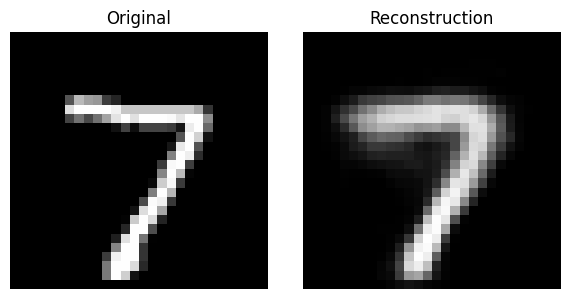

In [ ]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(x_one_np, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(x_rec_np, cmap="gray")
plt.title("Reconstruction")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
model = AE(latent_dim=3).to(device)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=y, cmap="tab10", s=25, alpha=0.8)
plt.colorbar(sc, ticks=range(10), label="digit")
ax.set_xlabel("z1")
ax.set_ylabel("z2")
ax.set_zlabel("z3")
plt.title("MNIST latent space (3D) — one test batch")
plt.show()

<p class="task" id="3"></p>

3\. Напишите функцию для генерации изображения на основе случайного шума. Функция должна генерировать случайный шум из стандартного нормального распределения и пропускать его через часть-декодировщик. Сгенерируйте несколько изображений и визуализируйте в виде сетки из картинок.

- [ ] Проверено на семинаре

In [ ]:
from torchvision.utils import make_grid

In [ ]:
@torch.no_grad()
def generate_images(model, n=25, latent_dim=2, device="cpu"):
    model.eval()
    z = torch.randn(n, latent_dim, device=device)
    x_gen = model.decode(z)
    x_gen = x_gen.clamp(0, 1)
    return x_gen

In [ ]:
n = 25
x_gen = generate_images(model, n=n, latent_dim=2, device=device)

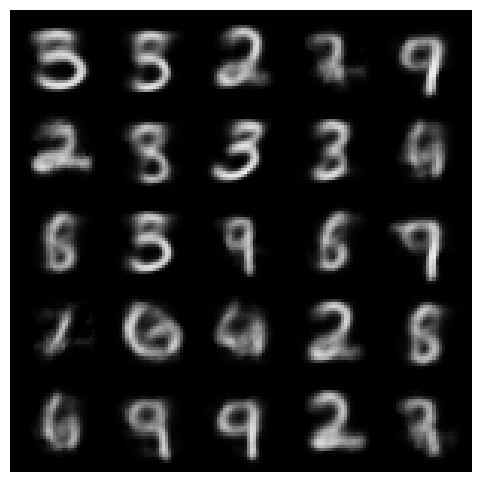

In [ ]:
grid = make_grid(x_gen.cpu(), nrow=5, padding=2)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()

<p class="task" id="4"></p>

4\. Создайте и обучите модель условного автокодировщика, используя только полносвязные слои и функции активации.

Отличие от предыдущего варианта заключается в том, что теперь функции кодировщика и декодировщика принимают на вход также метку класса:
$$z = f_\theta(x, c)$$
$$\hat{x} = g_\phi(z, c)$$

Таким образом, теперь во теперь время обучения метки классов используются. Задействуйте их следующим образом: представьте метки классов в виде one-hot кодировки и объедините с пикселями изображения (для этого адаптируйте размерность слоев).

Скрытое представление, полученное после части-кодировщика, должно иметь размерность 2. Последним слоем части-декодеровщика сделайте сигмоиду. В качестве функции потерь используйте `MSELoss` между исходным и восстановленным изображением $MSE(x, \hat{x})$.


- [ ] Проверено на семинаре

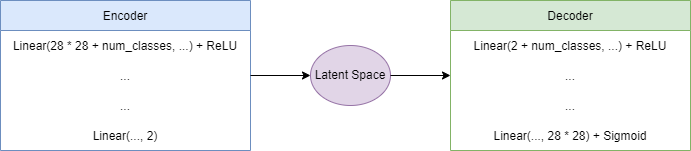

In [ ]:
class CAE(nn.Module):
    def __init__(self, latent_dim=2, num_classes=10):
        super().__init__()
        self.num_classes = num_classes

        self.encoder = nn.Sequential(
            nn.Linear(28*28 + num_classes, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 28*28), nn.Sigmoid()
        )

    def encode(self, x, y):
        x = x.view(x.size(0), -1)
        y_oh = F.one_hot(y, num_classes=self.num_classes).float().to(x.device)
        inp = torch.cat([x, y_oh], dim=1)
        return self.encoder(inp)

    def decode(self, z, y):
        y_oh = F.one_hot(y, num_classes=self.num_classes).float().to(z.device)
        inp = torch.cat([z, y_oh], dim=1)
        x_hat = self.decoder(inp)
        return x_hat.view(-1, 1, 28, 28)

    def forward(self, x, y):
        z = self.encode(x, y)
        x_hat = self.decode(z, y)
        return x_hat, z

In [ ]:
cmodel = CAE(latent_dim=2, num_classes=10).to(device)
opt = torch.optim.Adam(cmodel.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
def train_epoch():
    cmodel.train()
    total = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        x_hat, _ = cmodel(x, y)
        loss = criterion(x_hat, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item() * x.size(0)
    return total / len(train_loader.dataset)

In [ ]:
@torch.no_grad()
def eval_epoch():
    cmodel.eval()
    total = 0.0
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        x_hat, _ = cmodel(x, y)
        loss = criterion(x_hat, x)
        total += loss.item() * x.size(0)
    return total / len(test_loader.dataset)

In [ ]:
for epoch in range(1, 11):
    tr = train_epoch()
    te = eval_epoch()
    print(f"Epoch {epoch:02d}: train={tr:.5f} test={te:.5f}")

Epoch 01: train=0.05925 test=0.04196
Epoch 02: train=0.03958 test=0.03772
Epoch 03: train=0.03678 test=0.03611
Epoch 04: train=0.03548 test=0.03524
Epoch 05: train=0.03467 test=0.03454
Epoch 06: train=0.03406 test=0.03415
Epoch 07: train=0.03359 test=0.03379
Epoch 08: train=0.03323 test=0.03351
Epoch 09: train=0.03298 test=0.03326
Epoch 10: train=0.03272 test=0.03302


<p class="task" id="5"></p>

5\. Напишите функцию для генерации изображения на основе случайного шума. Функция должна генерировать случайный шум из стандартного нормального распределения и one-hot представление цифры. Далее объединенный вектор пропускается его через часть-декодировщик. Сгенерируйте несколько изображений и визуализируйте в виде сетки из картинок.

- [ ] Проверено на семинаре

In [ ]:
@torch.no_grad()
def generate_images_cond(model, digit, n=25, latent_dim=2, num_classes=10, device="cpu"):
    model.eval()
    z = torch.randn(n, latent_dim, device=device)
    y = torch.full((n,), digit, dtype=torch.long, device=device)
    y_oh = F.one_hot(y, num_classes=num_classes).float()
    inp = torch.cat([z, y_oh], dim=1)
    x_gen = model.decoder(inp).view(-1, 1, 28, 28)
    x_gen = x_gen.clamp(0, 1)
    return x_gen

In [ ]:
digit = 3
n = 25
x_gen = generate_images_cond(cmodel, digit=digit, n=n, latent_dim=2, num_classes=10, device=device)

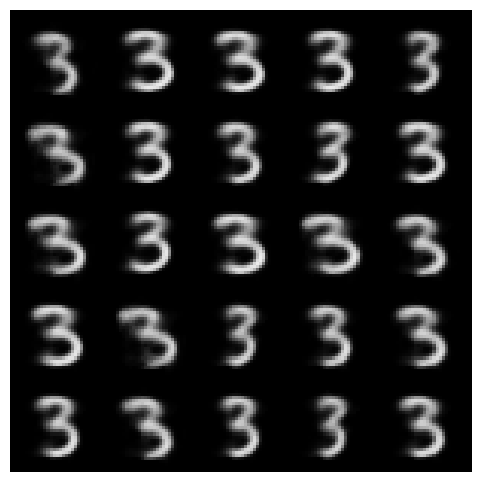

In [ ]:
grid = make_grid(x_gen.cpu(), nrow=5, padding=2)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()

<p class="task" id="6"></p>

6\. Создайте и обучите модель вариационного автокодировщика, используя только полносвязные слои и функции активации.

Кодировщик - это функция следующего вида:
$$q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \sigma_\phi^2(x))$$

Здесь $\phi$ - параметры кодировщика, а $\mu_\phi(x)$ и $\sigma_\phi^2(x)$ - это обучаемые функции (в нашем случае - полносвязные слои).

Чтобы иметь возможность обучить такую модель, используется т.н. reparametrization trick: на основе функций $\mu$ и $ \sigma$ считаем значение:

$$z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

Декодировщик пытается восстановить исходное изображение из полученного вектора:

$$p_\theta(x|z) = f(z; \theta)$$

В качестве функции потерь обычно используется следующая:
$$\mathcal{L}_{total} = \mathcal{L}_{recon} + D_{KL}$$
$$\mathcal{L}_{recon} = -\sum_{i=1}^D [x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i)]$$
$$D_{KL} = -\frac{1}{2} \sum_{j=1}^J (1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2)$$


- [ ] Проверено на семинаре

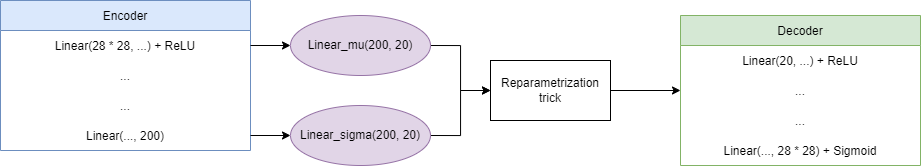

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 200), nn.ReLU()
        )
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 28*28), nn.Sigmoid()
        )

    def encode(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar, z

In [ ]:
def vae_loss(x, x_hat, mu, logvar):
    x = x.view(x.size(0), -1)
    x_hat = x_hat.view(x_hat.size(0), -1)

    L_recon = -(x * torch.log(x_hat + 1e-8) + (1 - x) * torch.log(1 - x_hat + 1e-8)).sum()
    D_kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum()
    return L_recon + D_kl

In [ ]:
vmodel = VAE(latent_dim=20).to(device)
opt = torch.optim.Adam(vmodel.parameters(), lr=1e-3)

In [ ]:
def train_epoch():
    vmodel.train()
    total = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar, _ = vmodel(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()
    return total / len(train_loader.dataset)

In [ ]:
@torch.no_grad()
def eval_epoch():
    vmodel.eval()
    total = 0.0
    for x, _ in test_loader:
        x = x.to(device)
        x_hat, mu, logvar, _ = vmodel(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        total += loss.item()
    return total / len(test_loader.dataset)

In [ ]:
for epoch in range(1, 11):
    tr = train_epoch()
    te = eval_epoch()
    print(f"Epoch {epoch:02d}: train={tr:.4f} test={te:.4f}")

Epoch 01: train=203.7291 test=172.1532
Epoch 02: train=155.3378 test=141.1360
Epoch 03: train=134.9579 test=129.6255
Epoch 04: train=128.2167 test=125.6163
Epoch 05: train=124.2482 test=122.3522
Epoch 06: train=121.2740 test=119.5875
Epoch 07: train=119.1217 test=118.5624
Epoch 08: train=117.0613 test=116.1051
Epoch 09: train=115.2957 test=114.4145
Epoch 10: train=113.6241 test=113.2154


<p class="task" id="7"></p>

7\. Напишите функцию для генерации изображения на основе случайного шума. Функция должна генерировать случайный шум из стандартного нормального распределения. Далее вектор пропускается его через часть-декодировщик. Сгенерируйте несколько изображений и визуализируйте в виде сетки из картинок.

- [ ] Проверено на семинаре

In [ ]:
@torch.no_grad()
def generate_images_vae(model, n=25, latent_dim=20, device="cpu"):
    model.eval()
    z = torch.randn(n, latent_dim, device=device)
    x_gen = model.decode(z)
    x_gen = x_gen.clamp(0, 1)
    return x_gen

In [ ]:
n = 25
x_gen = generate_images_vae(vmodel, n=n, latent_dim=20, device=device)

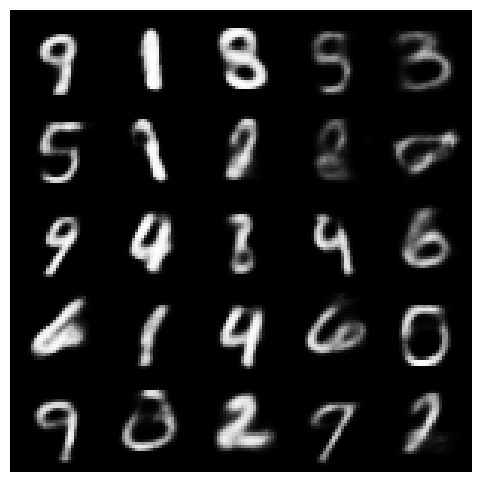

In [ ]:
grid = make_grid(x_gen.cpu(), nrow=5, padding=2)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()